# Physics-informed weighted Jacobi Iteration (PI-WJI) for coupled bubble systems

*A compact, hands-on guide to Physics-Informed Weighted Jacobi Iteration for coupled bubble systems.*

**What you’ll do**
- Run **single simulations** with different solvers (baseline-NumPy, PI-WJI (fitted), and BiCG).
- Perform a **parameter study** (brute-force ω search).
- Measure and compare **runtime/metrics** across solvers.
- Visualize **time-series** and **convergence**.

**What you’ll need**
- No local setup — just run the cells in order.
- The notebook will install minimal deps (tyro) and clone the repo.

**Outputs**
- Time series: `data_repository/time_series/.../*.npz`  
- Metrics: `data_repository/metrics/.../*.npz`  
- Runtimes: `data_repository/runtimes/`



## Initialization


In [5]:
#@title 1) Clone Repository and install tyro
%%capture setup_logs
!pip install tyro
!git clone https://github.com/kalmi901/PI-WJI.git
%cd PI-WJI/

In [7]:
#@title 2) Import moduls
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [8]:
#@title 3) Set Data Path
ROOT = Path.cwd()  # /contetn/PI-WJI
DATA_ROOT = ROOT / "data_repository"
CLUSTER_DATA     = DATA_ROOT / "cluster_data"
TIME_SERIES_DATA = DATA_ROOT / "time_series"
METRICS_DATA     = DATA_ROOT / "metrics"
RUNTIME_DATA     = DATA_ROOT / "runtime"

# Single Runs


`solve_bubble_cluster.py` runs a single simulation. If a matching cluster configuration is already present under `data_repository/cluster_data/`, it will be reused; otherwise the script generates it on the fly. Time-series outputs are written to `data_repository/time_series/...`.

**Flags you’ll use here**

- `--solver.measure simple` — disables metric collection and saves only the time-series curves.
- `--solver.bubble-model {baseline,jacobi_fitted,bicg}` — selects the linear solver:
  - `baseline`: NumPy’s direct solver (`np.linalg.solve`)
  - `jacobi_fitted`: PI-WJI with fitted coefficients
  - `bicg`: Bi-Conjugate Gradient
- `--solver.jacobi-params a b c` — PI-WJI coefficients, e.g. `0.5 0.5 -0.04`
- `--cluster.number-of-bubbles N`, `--cluster.seed S` — cluster size and RNG seed


The next cell will launch three simulations on a 32-bubble cluster with seed 42 and pressure amplitude $P_1=1.8\, \mathrm{bar}$

1. `baseline` (direct solver via `np.linalg.solve`)
2. `jacobi_fitted` (PI-WJI with coefficients `[0.5, 0.5, -0.04]`)
3. `bicg` (Bi-Conjugate gradient)

The first run will also generate the cluster data if it doesn’t exist yet.

In [4]:
# numpy.linalg.lsolve
!python src/solve_bubble_cluster.py \
    --cluster.number-of-bubbles 32  \
    --cluster.seed 42 \
    --solver.bubble-model baseline \
    --solver.measure simple \
    --general.P1 1.8

# BiCG
!python src/solve_bubble_cluster.py \
    --cluster.number-of-bubbles 32  \
    --cluster.seed 42 \
    --solver.bubble-model bicg \
    --solver.measure simple \
    --general.P1 1.8

# PI-WJI
!python src/solve_bubble_cluster.py \
    --cluster.number-of-bubbles 32  \
    --cluster.seed 42 \
    --solver.bubble-model jacobi_fitted \
    --solver.jacobi-params 0.5 0.5 -0.04 \
    --solver.measure simple \
    --general.P1 1.8


Generate a new scene with the actual properties
Loading scene from file.
The solver successfully reached the end of the integration interval.
The total simulation time was: 18.2009 seconds
stats: nfev=158767, njev=1122, nlu=1122
Loading scene from file.
The solver successfully reached the end of the integration interval.
The total simulation time was: 20.7204 seconds
stats: nfev=166339, njev=1194, nlu=1194
Loading scene from file.
The solver successfully reached the end of the integration interval.
The total simulation time was: 17.0416 seconds
stats: nfev=165446, njev=1161, nlu=1161


The results of the single-run simulations are written as compressed **`.npz`** files under:

`/content/PI-WJI/data_repository/time_series/N-32-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-42`

Example filenames (auto-generated from the run configuration):

- `P1-1.80-P2-25.00-P3-0.00-P4-0.00_baseline.npz`
- `P1-1.80-P2-25.00-P3-0.00-P4-0.00_bicg.npz`
- `P1-1.80-P2-25.00-P3-0.00-P4-0.00_jacobi_fitted.npz`

Each `.npz` stores three arrays (time series):

- `time` — **dimensionless** time, shape `(T,)`
- `radii` — **dimensionless** bubble radii, shape `(T, N)`
- `radii_micron` — bubble radii in **micrometers (µm)**, shape `(T, N)`

*Note:* The parent directory name encodes the cluster and excitation parameters (e.g., `N`, seeds, distance stats). Filenames encode `P1–P4`general parameters (pressure amplitudes and excitation frequencies) and the solver variant.

In [5]:
baseline = np.load(TIME_SERIES_DATA / "N-32-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-42" / "P1-1.80-P2-25.00-P3-0.00-P4-0.00_baseline.npz" )
bicg     = np.load(TIME_SERIES_DATA / "N-32-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-42" / "P1-1.80-P2-25.00-P3-0.00-P4-0.00_bicg.npz" )
piwji    = np.load(TIME_SERIES_DATA / "N-32-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-42" / "P1-1.80-P2-25.00-P3-0.00-P4-0.00_jacobi_fitted.npz" )

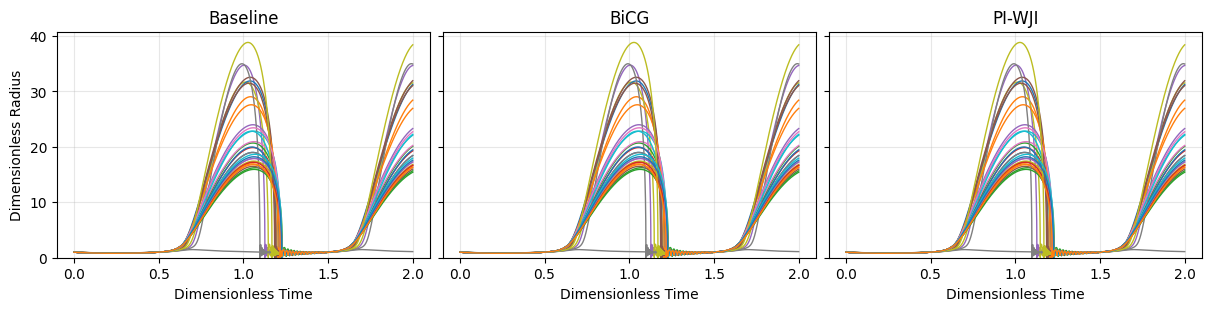

In [8]:
datasets = [
    ("Baseline", baseline),
    ("BiCG",     bicg),
    ("PI-WJI",    piwji),
]

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True, constrained_layout=True)

# (Opcionális) közös y-tartomány, hogy összehasonlítható legyen a skála
ymax = max(np.max(d["radii"]) for _, d in datasets)

for ax, (title, data) in zip(axes, datasets):
    ax.plot(data["time"], data["radii"], linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Dimensionless Time")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Dimensionless Radius")
for ax in axes:
    ax.set_ylim(0, ymax*1.05)

plt.show()

For the full list of available options, use the `--help` or `-h` flag.


In [5]:
!python src/solve_bubble_cluster.py --help

usage: solve_bubble_cluster.py [-h] [OPTIONS]

╭─ options ──────────────────────────────────────────────────────────────────╮
│ -h, --help                                                                 │
│     show this help message and exit                                        │
╰────────────────────────────────────────────────────────────────────────────╯
╭─ general options ──────────────────────────────────────────────────────────╮
│ Config for physical simulation parameters                                  │
│ ────────────────────────────────────────────────────────────────────────── │
│ --general.P1 FLOAT                                                         │
│     Pressure Amplitude 1 [bar] (default: 1.0)                              │
│ --general.P2 FLOAT                                                         │
│     Frequency 1 [kHz] (default: 25.0)                                      │
│ --general.P3 FLOAT                                                         │
│    

The results of the above simulations are stored in `.npz` format in the folder
`/content/PI-WJI/data_repository/time_series/N-32-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-42`

- `P1-1.20-P2-25.00-P3-0.00-P4-0.00_baseline.npz`
- `P1-1.20-P2-25.00-P3-0.00-P4-0.00_bicg.npz`
- `P1-1.20-P2-25.00-P3-0.00-P4-0.00_jacobi_fitted.npz`

Note that the folder and the filenames are auto-generated. To verify the simulation results, first compare the plots. Time-series data has three keys:
- `time` - dimensionless time with shape `(NSTEPS, )`
- `radii`- dimensionles radii of bubbles with shape `(NSTEPS, NBUBBLES)`
- `radii_micron` - radii of bubbles in micron with shape `(NSTEPS, NBUBBLES)`

# Parameter Study — Searching the Relaxation Parameter

To search for the optimal relaxation parameter, use `src/solve_bubble_cluster.py` with:

- `--solver.bubble-model jacobi_bruteforce` — brute-force search of the relaxation parameter.
- `--solver.measure linalg` — records linear-algebra metrics (iteration count, chosen ω, errors).

Below we reuse the previously generated cluster (`N=32`, `SEED=42`) and run **three** simulations at pressure amplitudes
$P_1 = 1.4\,\mathrm{bar}$, $1.8\,\mathrm{bar}$, and $2.4\,\mathrm{bar}$.
(Depending on Colab’s machine, this can take a while.)

Results will be saved under:

`/content/PI-WJI/data_repository/metrics/N-32-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-42`

Example files (auto-generated names):
- `P1-1.40-P2-25.00-P3-0.00-P4-0.00_jacobi_bruteforce.npz`
- `P1-1.80-P2-25.00-P3-0.00-P4-0.00_jacobi_bruteforce.npz`
- `P1-2.40-P2-25.00-P3-0.00-P4-0.00_jacobi_bruteforce.npz`

Each metrics file contains:
- `time` — dimensionless time stamps of the evaluations
- `omega` — relaxation parameter selected per evaluation
- `rmax` — maximum **dimensionless** radius across bubbles at each evaluation
- `iters` — iteration count per evaluation
- `linalg_error` — observed absolute error per evaluation

In [9]:
%%writefile omegasearch.sh
#!/usr/bin/env-bash

cd "$(dirname "$0")"

PYTHON=python       # or python3
SCRIPT=src/solve_bubble_cluster.py

# General Parametes
P2=25.0             # Excitation Frequency [kHz]
N=32                # Bubble Number
SEED=42             # Random State

for P1 in 1.4 1.8 2.2; do
    echo ">>> Running jacobi_bruteforce at P1=${P1} bar"
    $PYTHON "$SCRIPT"   --cluster.number-of-bubbles $N \
                        --cluster.seed $SEED \
                        --solver.bubble-model jacobi_bruteforce \
                        --solver.measure linalg \
                        --general.P1 $P1 \
                        --general.P2 $P2
done
echo "All runs finished."

Writing omegasearch.sh


In [10]:
# Make it executable and run
!chmod +x omegasearch.sh

In [11]:
!bash omegasearch.sh

>>> Running jacobi_bruteforce at P1=1.4 bar
Loading scene from file.
The solver successfully reached the end of the integration interval.
The total simulation time was: 185.2264 seconds
stats: nfev=182888, njev=1658, nlu=1658
>>> Running jacobi_bruteforce at P1=1.8 bar
Loading scene from file.
The solver successfully reached the end of the integration interval.
The total simulation time was: 211.3613 seconds
stats: nfev=171041, njev=1243, nlu=1243
>>> Running jacobi_bruteforce at P1=2.2 bar
Loading scene from file.
The solver successfully reached the end of the integration interval.
The total simulation time was: 229.1358 seconds
stats: nfev=170467, njev=1130, nlu=1130
All runs finished.


If you wish to recreate the results of Figure 3, re-run the above simulations using different number of bubbles and different seeds. For simlicity the full simulation is omitted from the present notebook.



## Recreating Figure 3

To reproduce Figure&nbsp;3, re-run the above simulations for multiple bubble numbers \(N\) and different random seeds.  
To keep this notebook lightweight, we omit the full study here; feel free to run it locally or extend the loop above.

For N=32, the fitted function is found to be

$\omega_{opt}^{approx}=0.5+0.5\cdot\exp(-0.04\cdot \max_i(x_1))$

Below, we present the results of the parameter study.

In [12]:
# Simulation Results
omega_14 = np.load(METRICS_DATA / "N-32-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-42" / "P1-1.40-P2-25.00-P3-0.00-P4-0.00_jacobi_bruteforce.npz" )
omega_18 = np.load(METRICS_DATA / "N-32-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-42" / "P1-1.80-P2-25.00-P3-0.00-P4-0.00_jacobi_bruteforce.npz" )
omega_22 = np.load(METRICS_DATA / "N-32-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-42" / "P1-2.20-P2-25.00-P3-0.00-P4-0.00_jacobi_bruteforce.npz" )

In [37]:
# Fitted Function
x = np.linspace(0, 80, 81)
omega = 0.5 + 0.5 * np.exp(-0.04 * x)

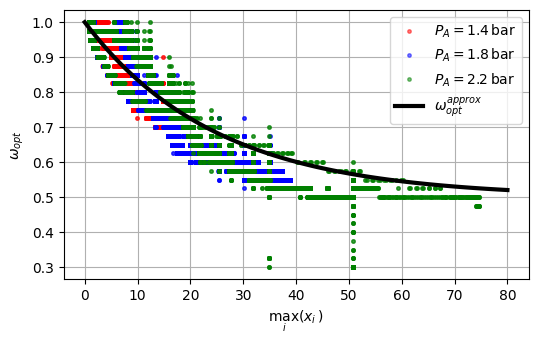

In [43]:
plt.figure(figsize=(6, 3.5))
plt.plot(omega_14["rmax"], omega_14["omega"], "r.", markersize=5, label=r"$P_{A}=1.4\, \mathrm{bar}$", alpha=0.5)
plt.plot(omega_18["rmax"], omega_18["omega"], "b.", markersize=5, label=r"$P_{A}=1.8\, \mathrm{bar}$", alpha=0.5)
plt.plot(omega_22["rmax"], omega_22["omega"], "g.", markersize=5, label=r"$P_{A}=2.2\, \mathrm{bar}$", alpha=0.5)
plt.plot(x, omega, "k-", linewidth=3, label=r"$\omega_{opt}^{approx}$")
plt.legend()
plt.xlabel(r"$\max_i(x_i)$")
plt.ylabel(r"$\omega_{opt}$")
plt.show()

## Comparison of the iteration numbers

In [56]:
#BiCG
!python src/solve_bubble_cluster.py \
    --cluster.number-of-bubbles 32  \
    --cluster.seed 42 \
    --solver.bubble-model bicg \
    --solver.measure linalg \
    --general.P1 2.2

#PI-WJI
!python src/solve_bubble_cluster.py \
    --cluster.number-of-bubbles 32  \
    --cluster.seed 42 \
    --solver.bubble-model jacobi_fitted \
    --solver.jacobi-params 0.5 0.5 -0.04 \
    --solver.measure linalg \
    --general.P1 2.2

Loading scene from file.
The solver successfully reached the end of the integration interval.
The total simulation time was: 13.5625 seconds
stats: nfev=176593, njev=1228, nlu=1228
Loading scene from file.
The solver successfully reached the end of the integration interval.
The total simulation time was: 13.1218 seconds
stats: nfev=178647, njev=1268, nlu=1268


In [57]:
omega_22_bicg  = np.load(METRICS_DATA / "N-32-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-42" / "P1-2.20-P2-25.00-P3-0.00-P4-0.00_bicg.npz" )
omega_22_piwji = np.load(METRICS_DATA / "N-32-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-42" / "P1-2.20-P2-25.00-P3-0.00-P4-0.00_jacobi_fitted.npz" )

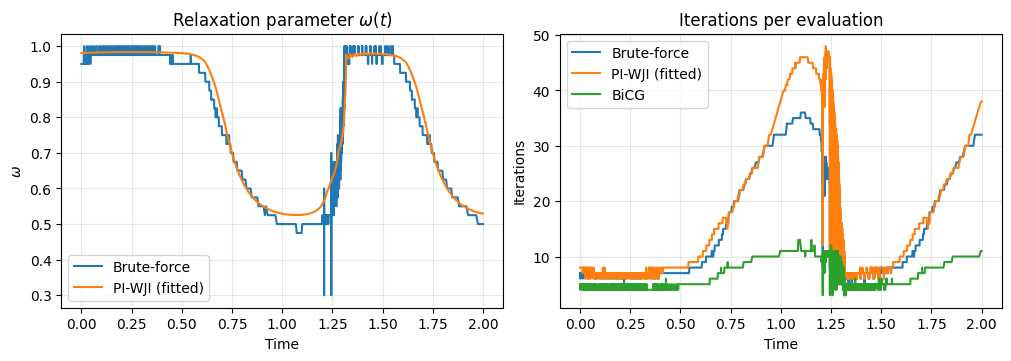

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5), sharex=True, constrained_layout=True)

# --- ω(t) ---
ax1.plot(omega_22["time"],        omega_22["omega"],        label="Brute-force")
ax1.plot(omega_22_piwji["time"],  omega_22_piwji["omega"],  label="PI-WJI (fitted)")
ax1.set_title(r"Relaxation parameter $\omega(t)$")
ax1.set_xlabel("Time")
ax1.set_ylabel(r"$\omega$")
ax1.grid(True, alpha=0.3)
ax1.legend()

# --- iterations(t) ---
ax2.plot(omega_22["time"],        omega_22["iters"],        label="Brute-force")
ax2.plot(omega_22_piwji["time"],  omega_22_piwji["iters"],  label="PI-WJI (fitted)")
ax2.plot(omega_22_bicg["time"],   omega_22_bicg["iters"],   label="BiCG")
ax2.set_title("Iterations per evaluation")
ax2.set_xlabel("Time")
ax2.set_ylabel("Iterations")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.show()

In [61]:
print("The total number of interations")
print(" -BiCG       : ", sum(omega_22_bicg["iters"]))
print(" -BruteForce : ", sum(omega_22["iters"]))
print(" -PI-WJI     : ", sum(omega_22_piwji["iters"]))

The total number of interations
 -BiCG       :  1076189
 -BruteForce :  1930377
 -PI-WJI     :  2643911


# Performance characteristics

The recommended way to measure performance characteristics is to use small **shell scripts** and control simulations via CLI flags. Here we benchmark **runtime** by setting `--solver.measure runtime` and comparing three solver variants:

- **PI-WJI** — `--solver.bubble-model jacobi_fitted` (with fitted coefficients)
- **Jacobi (baseline)** — `--solver.bubble-model jacobi_baseline`
- **BiCG** — `--solver.bubble-model bicg`

To keep this notebook lightweight, we evaluate on a **single cluster configuration** (e.g. \(N=32\), `seed=42`). The runtime measurement repeated three times.
The next cell generates and runs a short shell script that performs the sweep and saves runtime summaries under `data_repository/runtimes/...`.



In [26]:
%%writefile runtime.sh
#!/usr/bin/env-bash

cd "$(dirname "$0")"

PYTHON=python       # or python3
SCRIPT=src/solve_bubble_cluster.py

# General Parametes
P2=25.0             # Excitation Frequency [kHz]
N=32                # Bubble Number
SEED=42             # Random State

for P1 in 0.2 0.4 0.6 0.8 1.0 1.2 1.4 1.8 2.0; do
    echo ">>> Running baseline at P1=${P1} bar"
    $PYTHON "$SCRIPT"   --cluster.number-of-bubbles $N \
                        --cluster.seed $SEED \
                        --solver.bubble-model baseline \
                        --solver.measure runtime \
                        --solver.repeat-measure 3 \
                        --general.P1 $P1 \
                        --general.P2 $P2

    echo ">>> Running jacobi_fitted at P1=${P1} bar"
    $PYTHON "$SCRIPT"   --cluster.number-of-bubbles $N \
                        --cluster.seed $SEED \
                        --solver.bubble-model jacobi_fitted \
                        --solver.jacobi-params 0.5 0.5 -0.04 \
                        --solver.measure runtime \
                        --solver.repeat-measure 3 \
                        --general.P1 $P1 \
                        --general.P2 $P2

    echo ">>> Running bicg at P1=${P1} bar"
    $PYTHON "$SCRIPT"   --cluster.number-of-bubbles $N \
                        --cluster.seed $SEED \
                        --solver.bubble-model bicg \
                        --solver.measure runtime \
                        --solver.repeat-measure 3 \
                        --general.P1 $P1 \
                        --general.P2 $P2

    echo ">>> Running jacobi_baseline at P1=${P1} bar"
    $PYTHON "$SCRIPT"   --cluster.number-of-bubbles $N \
                        --cluster.seed $SEED \
                        --solver.bubble-model jacobi_baseline \
                        --solver.measure runtime \
                        --solver.repeat-measure 3 \
                        --general.P1 $P1 \
                        --general.P2 $P2
done
echo "All runs finished."

Overwriting runtime.sh


In [27]:
# Make it executable and run
!chmod +x runtime.sh

In [28]:
!bash runtime.sh

>>> Running baseline at P1=0.2 bar
Loading scene from file.
Warm-up simulation is ended
The solver successfully reached the end of the integration interval.
-----------------------
1/3 simulation is ended.
The solver successfully reached the end of the integration interval.
The total simulation time was: 0.9803 seconds
2/3 simulation is ended.
The solver successfully reached the end of the integration interval.
The total simulation time was: 0.9802 seconds
3/3 simulation is ended.
The solver successfully reached the end of the integration interval.
The total simulation time was: 1.4224 seconds
>>> Running jacobi_fitted at P1=0.2 bar
Loading scene from file.
Warm-up simulation is ended
The solver successfully reached the end of the integration interval.
-----------------------
1/3 simulation is ended.
The solver successfully reached the end of the integration interval.
The total simulation time was: 0.8968 seconds
2/3 simulation is ended.
The solver successfully reached the end of the i

In [29]:
# Load and Calculate the average runtime
baseline, bicg, piwiji, jacobi = [], [], [], []
P1s =  [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.8]
for P1 in P1s:
    runtime_baseline = np.load(RUNTIME_DATA / "N-32-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-42" / f"P1-{P1:.2f}-P2-25.00-P3-0.00-P4-0.00_baseline.npz" )
    runtime_bicg     = np.load(RUNTIME_DATA / "N-32-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-42" / f"P1-{P1:.2f}-P2-25.00-P3-0.00-P4-0.00_bicg.npz" )
    runtime_piwji    = np.load(RUNTIME_DATA / "N-32-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-42" / f"P1-{P1:.2f}-P2-25.00-P3-0.00-P4-0.00_jacobi_fitted.npz" )
    runtime_jacobi   = np.load(RUNTIME_DATA / "N-32-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-42" / f"P1-{P1:.2f}-P2-25.00-P3-0.00-P4-0.00_jacobi_baseline.npz" )

    baseline.append(np.mean(runtime_baseline["sim_time"]))
    bicg.append(np.mean(runtime_bicg["sim_time"]))
    piwiji.append(np.mean(runtime_piwji["sim_time"]))
    jacobi.append(np.mean(runtime_jacobi["sim_time"]))


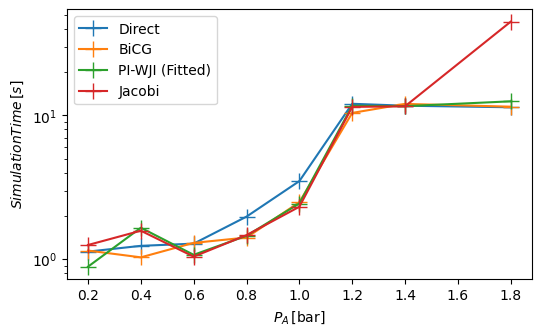

In [30]:
plt.figure(figsize=(6, 3.5))
plt.plot(P1s, baseline, "+-", markersize=12, label = "Direct" )
plt.plot(P1s, bicg, "+-", markersize=12, label = "BiCG" )
plt.plot(P1s, piwiji, "+-", markersize=12, label = "PI-WJI (Fitted)" )
plt.plot(P1s, jacobi, "+-", markersize=12, label = "Jacobi" )
plt.legend()
plt.xlabel(r"$P_{A}\, [\mathrm{bar}]$")
plt.ylabel(r"$Simulation Time\, [s]$")
plt.yscale("log")
plt.show()